# Perbandingan model Klasifikasi Naive Bayes dan Decision Tree  
menjelaskan proses dikritisasi menggunakan Kmean klastering pada data iris dan lakukan klasifikasi dengan model naive bayes dan decision tree pada data yang sudah deskritisasi dan sebelum deskritisasi 

Initial Data Inspection:
   id        class  petal_length  petal_width  sepal_length  sepal_width
0   1  Iris-setosa           1.4          0.2           4.4          3.2
1   2  Iris-setosa           1.4          0.2           4.9          3.0
2   3  Iris-setosa           1.3          0.2           4.7          3.2
3   4  Iris-setosa           1.5          0.2           4.6          3.1
4   5  Iris-setosa           1.4          0.2           5.0          3.6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            150 non-null    int64  
 1   class         150 non-null    object 
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   sepal_length  150 non-null    float64
 5   sepal_width   150 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None

Descriptive Statistic

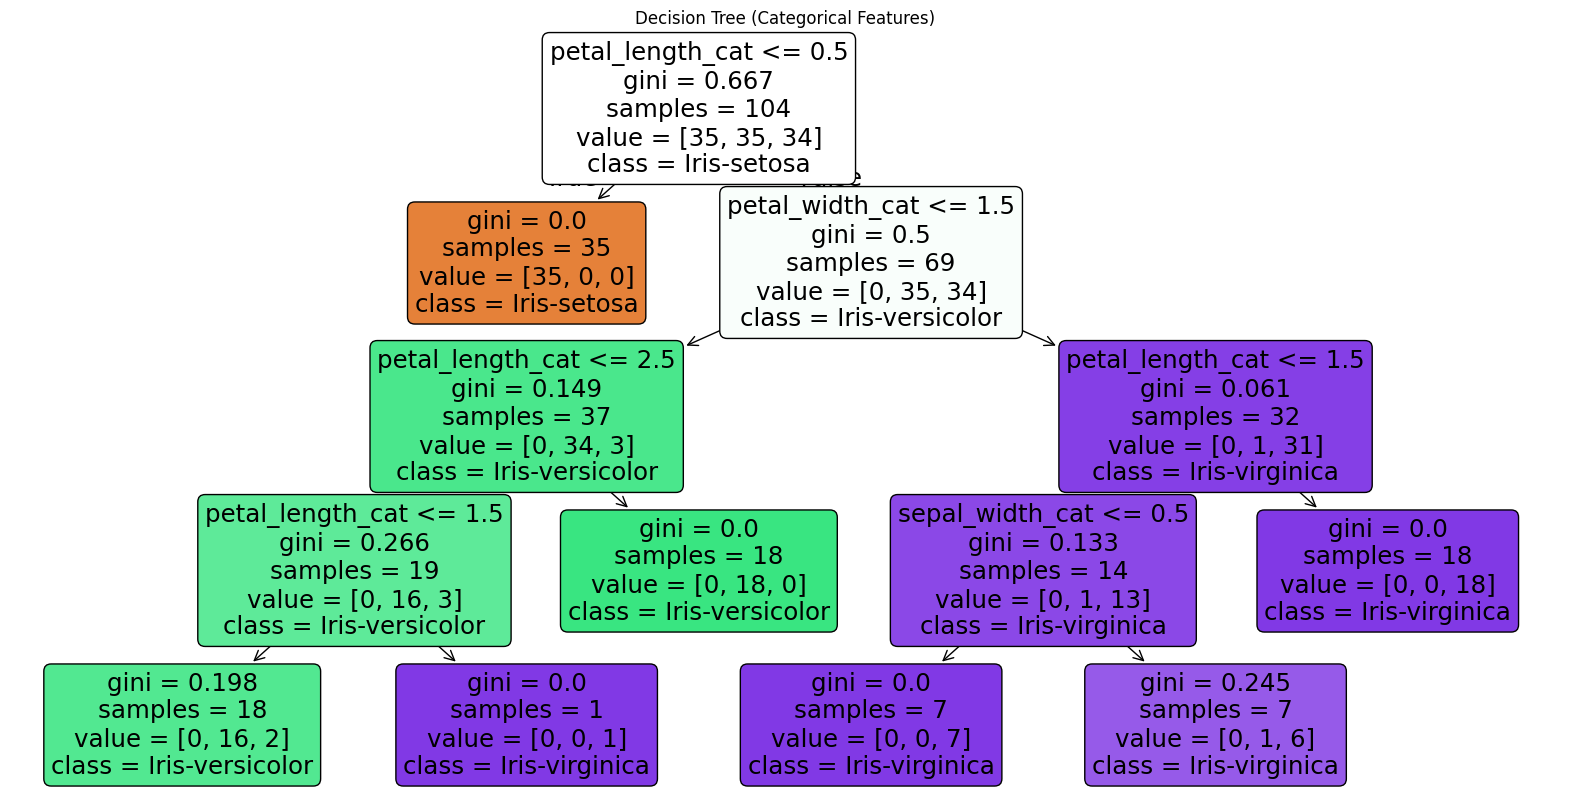


Running analysis with numerical features...

GaussianNB Performance:
Accuracy: 0.9333333333333333
Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.83      1.00      0.91        15
 Iris-virginica       1.00      0.80      0.89        15

       accuracy                           0.93        45
      macro avg       0.94      0.93      0.93        45
   weighted avg       0.94      0.93      0.93        45


DecisionTreeClassifier Performance:
Accuracy: 0.9333333333333333
Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      0.80      0.89        15
 Iris-virginica       0.83      1.00      0.91        15

       accuracy                           0.93        45
      macro avg       0.94      0.93      0.93        45
   weighted avg       0.94      0.93      0

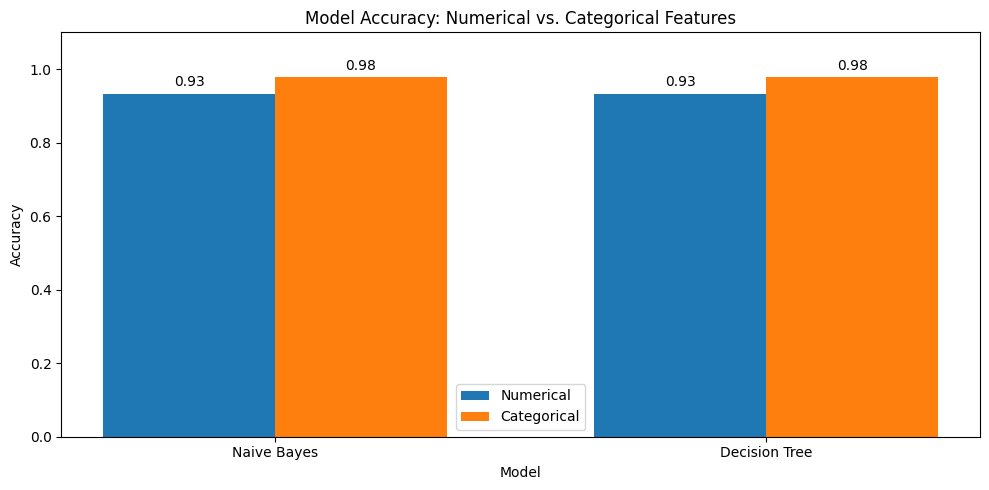

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree

# Load data
data = pd.read_csv('combined_data.csv')

# Data inspection
print("Initial Data Inspection:")
print(data.head())
print(data.info())
print("\nDescriptive Statistics:")
print(data.describe())

# Data cleaning
def clean_data(df):
    """Handle missing values and outliers"""
    # Drop row with extreme outlier (row 101)
    df = df.drop(101, axis=0).reset_index(drop=True)
    
    # Handle any remaining missing values
    df = df.dropna()
    
    return df

data = clean_data(data)

# Discretization function with improved error handling
def categorical_discretization_kbins(feature_data, n_bins, strategy, categories):
    """Discretize continuous features with proper validation"""
    try:
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        bins = discretizer.fit_transform(feature_data.values.reshape(-1, 1))
        return [categories[int(bin)] for bin in bins.flatten()]
    except Exception as e:
        print(f"Error in discretization: {e}")
        return feature_data  # Return original if discretization fails

# Apply discretization with meaningful category names
data['sepal_length_cat'] = categorical_discretization_kbins(
    data[['sepal_length']], n_bins=4, strategy='kmeans', 
    categories=['A', 'B', 'C', 'D'])

data['sepal_width_cat'] = categorical_discretization_kbins(
    data[['sepal_width']], n_bins=3, strategy='kmeans', 
    categories=['E', 'F', 'G'])

data['petal_width_cat'] = categorical_discretization_kbins(
    data[['petal_width']], n_bins=3, strategy='kmeans', 
    categories=['L', 'M', 'N'])

data['petal_length_cat'] = categorical_discretization_kbins(
    data[['petal_length']], n_bins=4, strategy='kmeans', 
    categories=['H', 'i', 'J', 'K'])

# Data preparation
def prepare_data(df, use_categorical=True):
    """Prepare data for modeling with option for categorical or numerical features"""
    if use_categorical:
        features = df[['sepal_length_cat', 'sepal_width_cat', 
                      'petal_length_cat', 'petal_width_cat']]
        encoder = OrdinalEncoder()
        X = encoder.fit_transform(features)
    else:
        features = df[['sepal_length', 'sepal_width', 
                      'petal_length', 'petal_width']]
        X = features.values
        
    y = df['class'].factorize()[0]
    return X, y, features.columns

# Split data function with stratification
def split_data(X, y, test_size=0.3, random_state=42):
    return train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)

# Model training and evaluation
def train_and_evaluate(model, X_train, X_test, y_train, y_test, target_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{model.__class__.__name__} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    return model, y_pred

# Main analysis
def run_analysis(use_categorical=True):
    print(f"\nRunning analysis with {'categorical' if use_categorical else 'numerical'} features...")
    
    X, y, feature_names = prepare_data(data, use_categorical)
    X_train, X_test, y_train, y_test = split_data(X, y)
    target_names = data['class'].unique()
    
    # Naive Bayes
    nb_model = CategoricalNB() if use_categorical else GaussianNB()
    nb_model, y_pred_nb = train_and_evaluate(
        nb_model, X_train, X_test, y_train, y_test, target_names)
    
    # Decision Tree
    dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
    dt_model, y_pred_dt = train_and_evaluate(
        dt_model, X_train, X_test, y_train, y_test, target_names)
    
    # Visualize Decision Tree if categorical
    if use_categorical:
        plt.figure(figsize=(20,10))
        tree.plot_tree(dt_model, 
                      feature_names=feature_names, 
                      class_names=target_names,
                      filled=True, rounded=True)
        plt.title(f"Decision Tree ({'Categorical' if use_categorical else 'Numerical'} Features)")
        plt.show()
    
    return {
        'nb_accuracy': accuracy_score(y_test, y_pred_nb),
        'dt_accuracy': accuracy_score(y_test, y_pred_dt)
    }

# Run analyses for both numerical and categorical features
results_cat = run_analysis(use_categorical=True)
results_num = run_analysis(use_categorical=False)

# Comparative visualization
def plot_comparison(results_num, results_cat):
    models = ['Naive Bayes', 'Decision Tree']
    num_acc = [results_num['nb_accuracy'], results_num['dt_accuracy']]
    cat_acc = [results_cat['nb_accuracy'], results_cat['dt_accuracy']]
    
    x = np.arange(len(models))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(x - width/2, num_acc, width, label='Numerical')
    rects2 = ax.bar(x + width/2, cat_acc, width, label='Categorical')
    
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Accuracy: Numerical vs. Categorical Features')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.set_ylim(0, 1.1)
    
    # Add value labels
    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_comparison(results_num, results_cat)

Kode Python di atas merupakan sebuah pipeline komprehensif untuk membandingkan performa dua model klasifikasi—**Naive Bayes** dan **Decision Tree**—dengan menggunakan dua pendekatan representasi fitur yang berbeda, yaitu numerik dan kategorikal. Proses dimulai dengan membaca dataset dari file `combined_data.csv`, kemudian dilakukan inspeksi awal terhadap data untuk melihat struktur, tipe data, dan statistik deskriptif. Tahap berikutnya adalah *data cleaning*, di mana data yang dianggap outlier ekstrem (baris ke-101) dihapus, kemudian data yang mengandung nilai *missing* juga dibersihkan. Setelah data bersih, dilakukan *discretization* atau pengubahan data numerik menjadi kategori menggunakan `KBinsDiscretizer` dengan strategi `kmeans`. Masing-masing fitur seperti panjang dan lebar kelopak maupun sepal dikonversi ke dalam beberapa kategori simbolik yang lebih bermakna (misalnya, ‘A’, ‘B’, ‘C’ untuk panjang sepal), yang kemudian akan digunakan untuk klasifikasi berbasis data kategorikal.

Selanjutnya, terdapat fungsi `prepare_data` yang menyiapkan data baik dalam bentuk kategorikal (menggunakan `OrdinalEncoder`) maupun numerik murni. Setelah itu, data dibagi menjadi data latih dan data uji menggunakan `train_test_split` dengan stratifikasi agar proporsi kelas tetap seimbang. Pada tahap pemodelan, dua model diterapkan: **CategoricalNB** digunakan jika fitur berupa kategori, dan **GaussianNB** untuk data numerik, sedangkan **DecisionTreeClassifier** digunakan pada kedua jenis data dengan pengaturan maksimal kedalaman pohon (max\_depth=4). Model dilatih, diprediksi, dan dievaluasi menggunakan akurasi serta *classification report* yang menampilkan precision, recall, dan f1-score. Khusus untuk fitur kategorikal, pohon keputusan divisualisasikan agar dapat dipahami bagaimana pohon memecah data berdasarkan kategori.

Setelah menjalankan analisis pada kedua representasi data, hasil akurasi dari masing-masing model dan representasi disimpan untuk perbandingan. Akhirnya, grafik batang dibuat untuk memvisualisasikan akurasi masing-masing model dengan fitur numerik dan kategorikal, yang membantu dalam mengidentifikasi mana pendekatan yang lebih efektif. Keseluruhan pipeline ini memberikan wawasan menyeluruh mengenai pengaruh representasi data terhadap performa model klasifikasi serta menunjukkan fleksibilitas dan kekuatan dari preprocessing serta model interpretatif seperti decision tree.
